# Introduction: Finding Prevalence from Observations

In this notebook, we'll look at solving the following statistics problem in a Bayesian Framework. (Problem courtesy of Allen Downey on Twitter: [tweet link](https://twitter.com/AllenDowney/status/1063460263716892674))

> Today's Bayesian problem of the week: Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
During the tour, we see 3 lions, 2 tigers, and 1 bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.
What is the probability that the next animal we see is a bear?

> Solution next week!

Our goal is to estimate the percentage of each species and determine the probability that the next animal is a bear. 

## Bayesian Approach

In a frequentist view, we would just use the observed animals to estimate the prevalence and let the data completely speak for itself. In contrast, in a Bayesian framework, we incorporate priors, which here are set to be equal for all species. In the case of infinite observations, the effect of the priors disappear and we only use the data. Due to the limited number of observations, the _priors_ will still have an large effect on the prevalence we obtain, and the _uncertainty_ will be large. We can alter the weight of the priors depending on our confidence in them (we'll see this in the notebook).

# Model

The overall system is as follows (each part will be explained):

1. The underlying model is a multinomial distribution with parameters $p_k$
2. The _prior_ distribution of $p_k$ is a Dirichlet Distribution
3. The $\alpha$ vector is a parameter of the prior Dirichlet Distribution, hence a _hyperparameter_

A Multinomial Distribution with a Dirichlet Prior is referred to as a [Dirichlet-Multinomial Distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution). 

Our model can be expressed in equations as:

$${\begin{array}{lclcl}{\boldsymbol {\alpha }}&=&(\alpha _{1},\ldots ,\alpha _{K})&=&{\text{concentration hyperparameter}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}&=&(p_{1},\ldots ,p_{K})&\sim &\operatorname {Dir} (K,{\boldsymbol {\alpha }})\\\mathbb {X} \mid \mathbf {p} &=&(x_{1},\ldots ,x_{K})&\sim &\operatorname {Mult} (K,\mathbf {p} )\end{array}}$$

Our goal is to find $p_\text{lions}$, $p_\text{tigers}$, $p_\text{bears}$ given the observation vector $c = [c_{lions}, c_{tigers}, c_{bears}]$

## Multinomial Distribution

This problem is a classic example of the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) which describes a situation in which we have n independent trials, each with k possible outcomes. With the wildlife preserve problem, n = 6 and k = 3. It is characterized by the probability of each outcome, $p_k$ which must sum to 1. Our goal is to find $p_\text{lions}$, $p_\text{tigers}$, $p_\text{bears}$ given the observations lions: 3, tigers: 2, and bears: 1.

## Dirichlet Distribution

The prior for a multinomial distribution in Bayesian statistics is a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). (Together, a multinomial distribution with a dirichlet prior is called, not surprisingly, a [Dirichlet-Multinomial Distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution). The Dirichlet distribution is characterized by $\alpha$, the concentration hyperparameter vector. 

## Hyperparameters and Prior Beliefs

The $\alpha$ vector is a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter), a parameter of a prior distribution. This vector in turn could have its _own prior_ distribution which is called a [_hyperprior_](https://en.wikipedia.org/wiki/Hyperprior). We won't use a hyperprior, but instead will only specify the hyperparameters.

The hyperparameter vector can be thought of as pseudo-counts, which we use to show our prior belief for the prevalence of each species. If want a uniform hyperparameter reflecting that we believe the chance of observing any species is the same we set each element of alpha equal such as $\alpha = [1, 1, 1]$. We can increase our decrease the effect of the priors by increasing or decreasing the values. This can be useful when we have more or less confidence in our prior beliefs. We'll see the effects of adjusting the hyperparameters in the notebook, but will mainly work with $\alpha = [1, 1, 1]$. 

The most helpful way to think of the $\alpha$ vector is as our prior beliefs. We encode these using pseudocounts, and, if we initially think each species has the same prevalence, then we set the pseudocounts to be equal.

With the basic model in place, let's get to working through this problem! 

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

# Problem Specifics

We'll mainly use one version of the hyperparameters, $\alpha = [1, 1, 1]$. We'll also try some other values to see how that changes the problem. Remember, altering the hyperparameters is like chaning our confidence in our initial beliefs.

In [2]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

# Expected Value

Source: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf

One way to get a single point estimate of the prevalence is to use the __expected value__ of the posterior for $p_k$. The expected value of a Dirichlet-Multinomial Distribution is:

$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$

Using $\alpha = [1, 1, 1]$, and the observation vector $c = [3, 2, 1]$ we get the expected prevalances:

$$p_{lions} = \frac{4}{9} = 44.4\%$$
$$p_{tigers} = \frac{3}{9} = 33.3\%$$
$$p_{bears} = \frac{2}{9} = 22.2\%$$

However, at least to me, this result is unsatisfying because it does not show our uncertainty due to the limited amount of data. For that, we turn to Bayesian modeling and sampling from the posterior with MCMC (in a little bit). The expected value represents our best guess for a single trial. We can also alter the expected value by adjusting the weight of the hyperparameter vector.

First, let's confirm our math using the default alpha vector.

In [3]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


This is as expected.

In [4]:
display_probs(dict(zip(animals, (4/9, 3/9, 2/9))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


Now, let's try a few different hyperparameter values (our previous beliefs) and see how that affects the expected value.

In [5]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


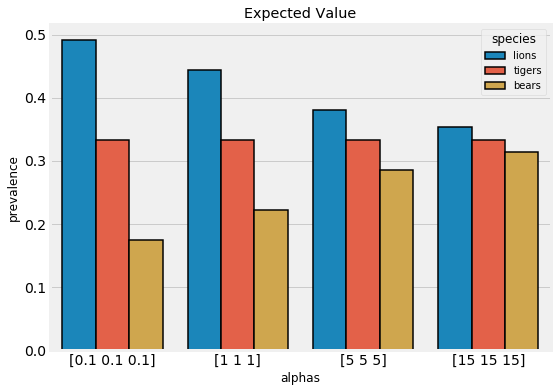

In [6]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

We see that as the weight of the hyperparameters increases, the expected prevalence of the species converges to around 1/3. Intuitively, this makes sense: as we increase the number of pseudocounts, we express more strongly our initial belief of the equal prevalence. With heavier priors, the data (observations) matters less. 

On the other hand, when we decrease the weight of the hyperparameters, the data matters more and the expected value converges on the counts.The ultimate choice of the hyperparameters depends on our confidence in our prior belief. 

# Maximum A Posterior Estimation

Source: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf

The maximum a posterior (MAP) is another point estimate that is equal to the mode of the posterior distribution. The MAP for a Dirichlet-Multinomial is: 

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

In the case of $\alpha = [1, 1, 1]$ this becomes the frequency observed in the data.

In [7]:
display_probs(dict(zip(animals, (alphas + c - 1) / sum(alphas + c - 1))))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


In [8]:
display_probs(dict(zip(animals, c / c.sum())))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


Again, this estimate is reasonable because with our choice of hyperparameters, we are considering only the data for the MAP. Let's look at what happens when we change the hyperparameters.

In [9]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c - 1) / sum(alpha_new + c - 1))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1 1 1]
2,0.388889,0.333333,0.277778,[5 5 5]
3,0.354167,0.333333,0.312500,[15 15 15]


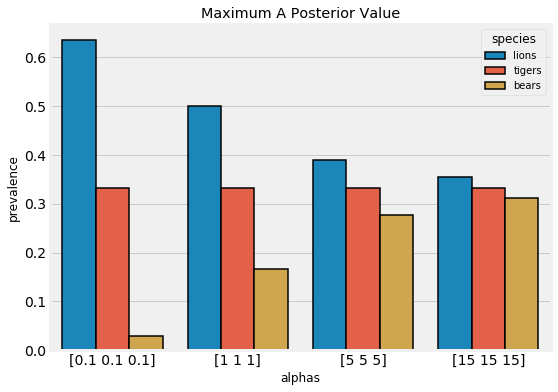

In [10]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Maximum A Posterior Value');

The same effect occurs, representing our decreased or increased confidence in the prior belief.

Both the Expected Value and Maximum A Posterior only provide a point estimate with no uncertainty. Given the relatively few observations, there should be a large amount of uncertainty; to capture that, we turn to Bayesian Modeling.

# Bayesian Model

Now we'll get into building and sampling from a Bayesian model. As a reminder, we are using a multinomial as our model, a Dirichlet distribution as the prior, and a specified hyperparameter vector. The objective is to find the _parameters_ of the multinomial, $p_k$ which are the probability of each species given the evidence. 

$$(\mathbf {p} \mid \mathbb  {X}, {\boldsymbol {\alpha}})$$

### PyMC3 and MCMC

To solve the problem, we'll build a model in [PyMC3](https://docs.pymc.io/) and then use a variant of Markov Chain Monte Carlo (the No-UTurn Sampler specifically) to draw samples from the posterior. With enough samples, the estimate will converge on the true posterior. Along with single point estimates (such as the mean of sampled values), MCMC also gives us built in uncertainty because we get thousands of possible values from the posterior.


Building a model in PyMC3 is simple. Each distribution is specified, along with the required parameters. We assign the observed counts to the `observed` parameter of the multinomial which in turn has the Dirichlet as the prior. 

We'll use $\alpha = [1, 1, 1]$ for our main model.

In [11]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    

In [12]:
model

## Sampling from the Model

The cell below samples 1000 draws from the posterior in 2 chains. We use 500 samples for tuning which are discarded. This means that for each random variable  in the model - the `parameters` - we will have 2000 values drawn from the posterior distribution. 

In [13]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 204.60draws/s]


## Inspecting Results

PyMC3 offers comprehensive tools for inspecting the results of a trace. We can start by getting the stats in a dataframe.

In [14]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.442073,0.151600,0.003309,0.163009,0.736219,2054.330035,1.000120
tigers,0.335250,0.146021,0.003246,0.075918,0.627365,2080.440210,0.999542
bears,0.222677,0.126508,0.002890,0.010689,0.461220,2165.502290,0.999999


We can see that the mean of the samples is very close to the expected value. However, instead of just getting one number, we get a range of uncertainty as indicated by the large standard deviation and 95% highest probability interval.

In [15]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.431007,0.280997,0.287996
1,0.431007,0.280997,0.287996
2,0.495291,0.263910,0.240799
3,0.516951,0.472085,0.010964
4,0.536711,0.320902,0.142387


In [16]:
trace_df.shape

(2000, 3)

For a single point estimate, we can use the mean of the samples.

In [17]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(animals, pvals)))

Species: lions    Prevalence: 44.21%.
Species: tigers   Prevalence: 33.52%.
Species: bears    Prevalence: 22.27%.


These numbers align nearly exactly with the expected values! However, we also get a range of uncertainty.

In [18]:
summary.iloc[:, 3:5]

,hpd_2.5,hpd_97.5
lions,0.163009,0.736219
tigers,0.075918,0.627365
bears,0.010689,0.461220


We can see the large amount of uncertainty in the estimates due to the limited amount of data. To see the estimates and uncertainty visually, we can use some of PyMC3's built in plots.

# Diagnostic Plots

PyMC3 offers a number of [plotting options](https://docs.pymc.io/api/plots.html) for inspecting our samples.

## Posterior Plot

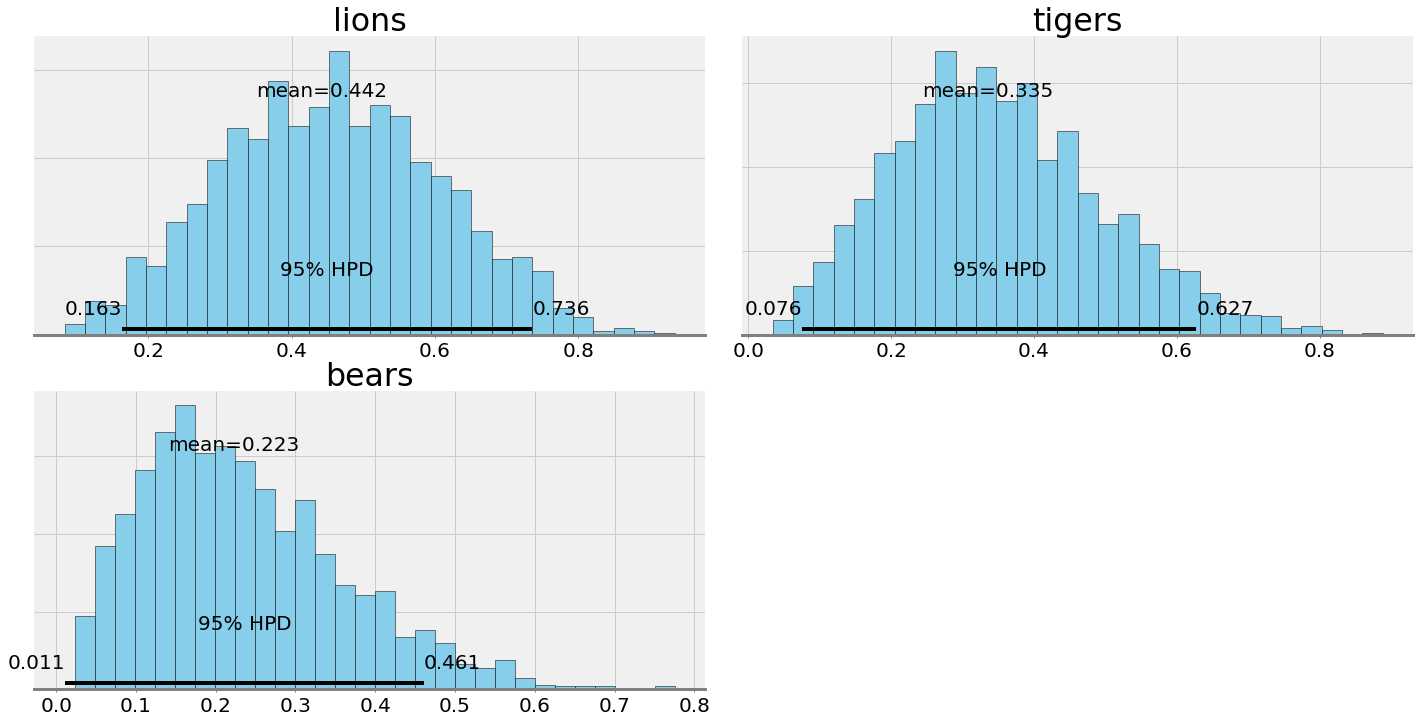

In [19]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

What we see hear is a histogram of the sampled values. 

The 95% HPD is the same idea as a 95% confidence interval in frequentist statistics. In Bayesian stats, this is called the Highest Posterior Density.

## Traceplot

The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (`combined = True`) but in reality we drew 2 independent chains.

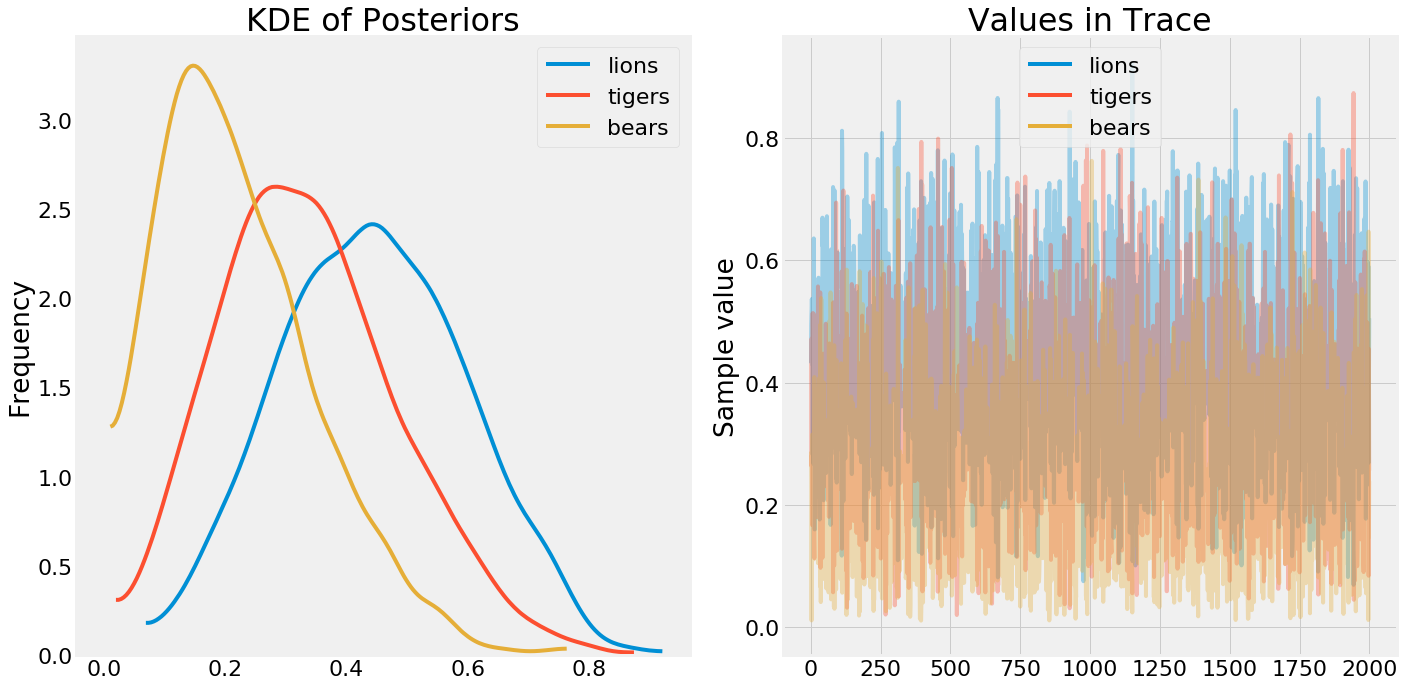

In [20]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 10), combined = True);
ax[0][0].set_title('KDE of Posteriors'); ax[0][1].set_title('Values in Trace');
add_legend(ax[0][0])
add_legend(ax[0][1])

Even here we see a large amount of uncertainty although the model is clear that $p_{bears} < p_{tigers} < p_{lions}$.

## Maximum A Posteriori Result with PyMC3

PyMC3 has a method for directly finding the MAP.

In [21]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))

logp = -1.8042, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 1754.31it/s]


Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


The MAP estimates are exactly the same as the observations. These are also the results that a frequentist would come up with! 

# Sample From Posterior

We can now use the posterior (contained in the `trace`) to draw samples of data. For example, we can simulate 1000 trips to the wildlife preserve as follows.

In [22]:
with model:
    samples = pm.sample_ppc(trace, samples = 1000)
    
dict(zip(animals, samples['observed_data'].mean(axis = 0)))

100%|██████████| 1000/1000 [00:00<00:00, 1017.90it/s]


{'lions': 2.692, 'tigers': 1.995, 'bears': 1.313}

These represent the estimate number of each species we'd see over 1000 trips to the preserve.

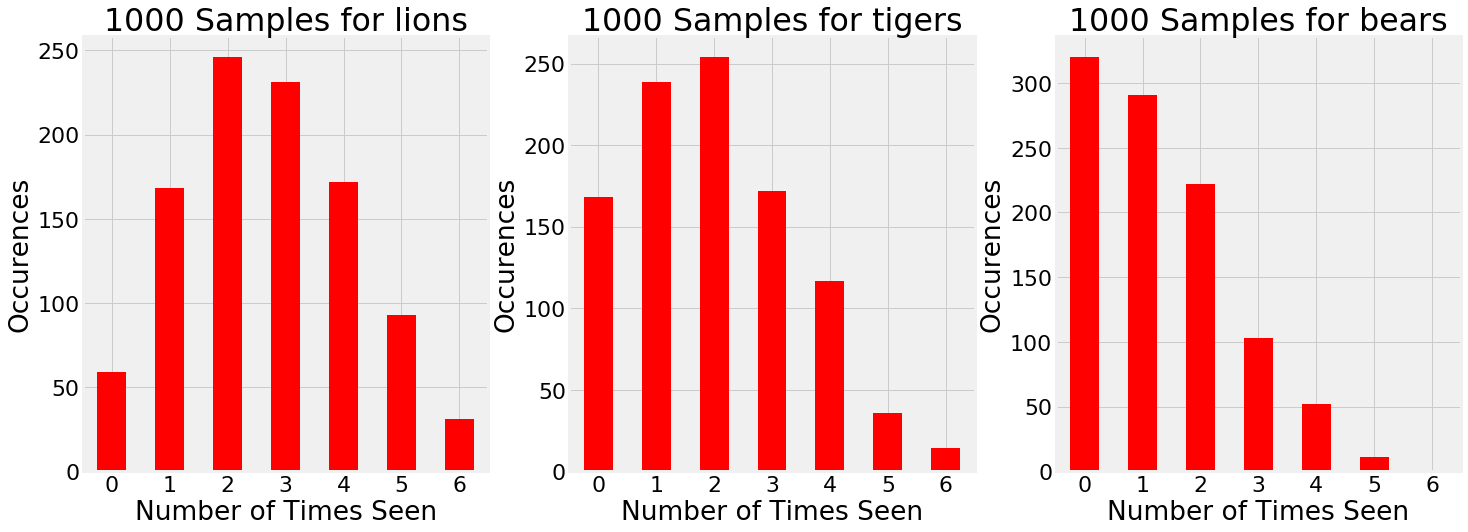

In [23]:
sample_df = pd.DataFrame(samples['observed_data'], columns = animals)

plt.figure(figsize = (22, 8))
for i, animal in enumerate(sample_df):
    plt.subplot(1, 3, i+1)
    sample_df[animal].value_counts().sort_index().plot.bar(color = 'r');
    plt.xticks(range(7), range(7), rotation = 0);
    plt.xlabel('Number of Times Seen'); plt.ylabel('Occurences');
    plt.title(f'1000 Samples for {animal}');

Even though it's not very likely, it's possible we could see 6 bears and 0 lions and 0 tigers.

# Dirichlet Distribution

We can plot the Dirichlet Distribution as a triangle with colors indicating the value of the hyperparameters. This code is taken from the following sources.

http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

https://gist.github.com/tboggs/8778945

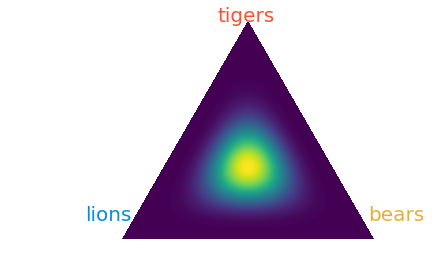

In [24]:
draw_pdf_contours(Dirichlet(6 * alphas))
annotate_plot()

Initially, the probability for all species is equalvalent. After our sampling though we see the balance shift towards the lions.

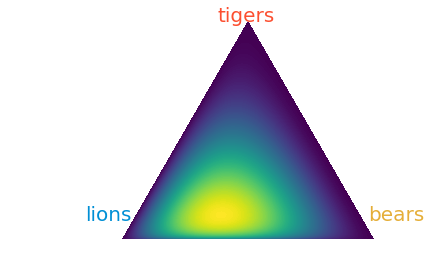

In [25]:
draw_pdf_contours(Dirichlet(6 * pvals))
annotate_plot();

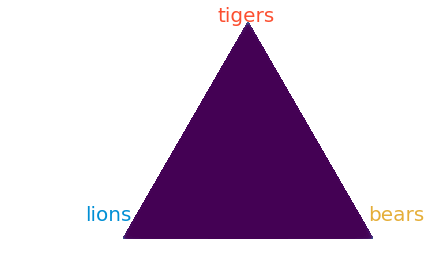

In [39]:
draw_pdf_contours(Dirichlet([0.1, 0.1, 0.1]))
annotate_plot();

# Next Observation

In order to find what we can expect from the next observation, we draw a single sample 10000 times from a multinomial distribution. The probability of seeing each species is proportional to that obtained from the sampling.

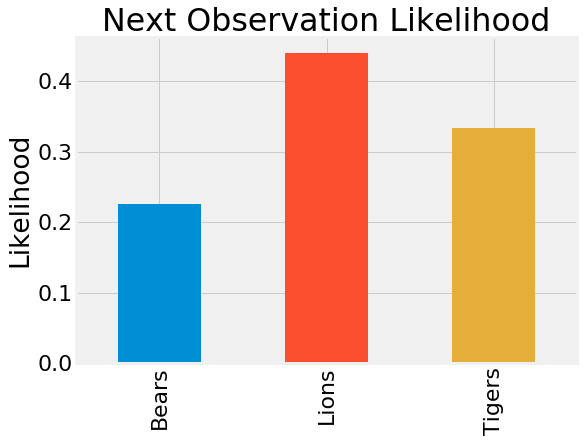

In [26]:
# Draw from the multinomial
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [27]:
next_obs.iloc[:, [0, 2]]

,variable,total
1,Bears,0.2259
3,Lions,0.4407
5,Tigers,0.3334


# More Observations

If we have additional observations, more trips to the preserve, we can easily do the sampling taking into account this data. 

In [28]:
c = np.array([[3, 2, 1],
              [2, 3, 1],
              [3, 2, 1],
              [2, 3, 1]])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 370.70draws/s]


In [29]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.407799,0.091164,0.001813,0.238817,0.595130,2190.753843,1.000270
tigers,0.405678,0.092595,0.002054,0.220425,0.583333,2125.337697,1.000164
bears,0.186523,0.075623,0.001722,0.052582,0.331158,2042.839721,0.999504


The uncertainty of the prevalence of bears has decreased and the prevalence of the lions and tigers is nearly identical as expected from the data. As we gather more data, we can incorporate it into the model to get more accurate estimates. A larger amount of data will mean less uncertainty in the sampling as well. 

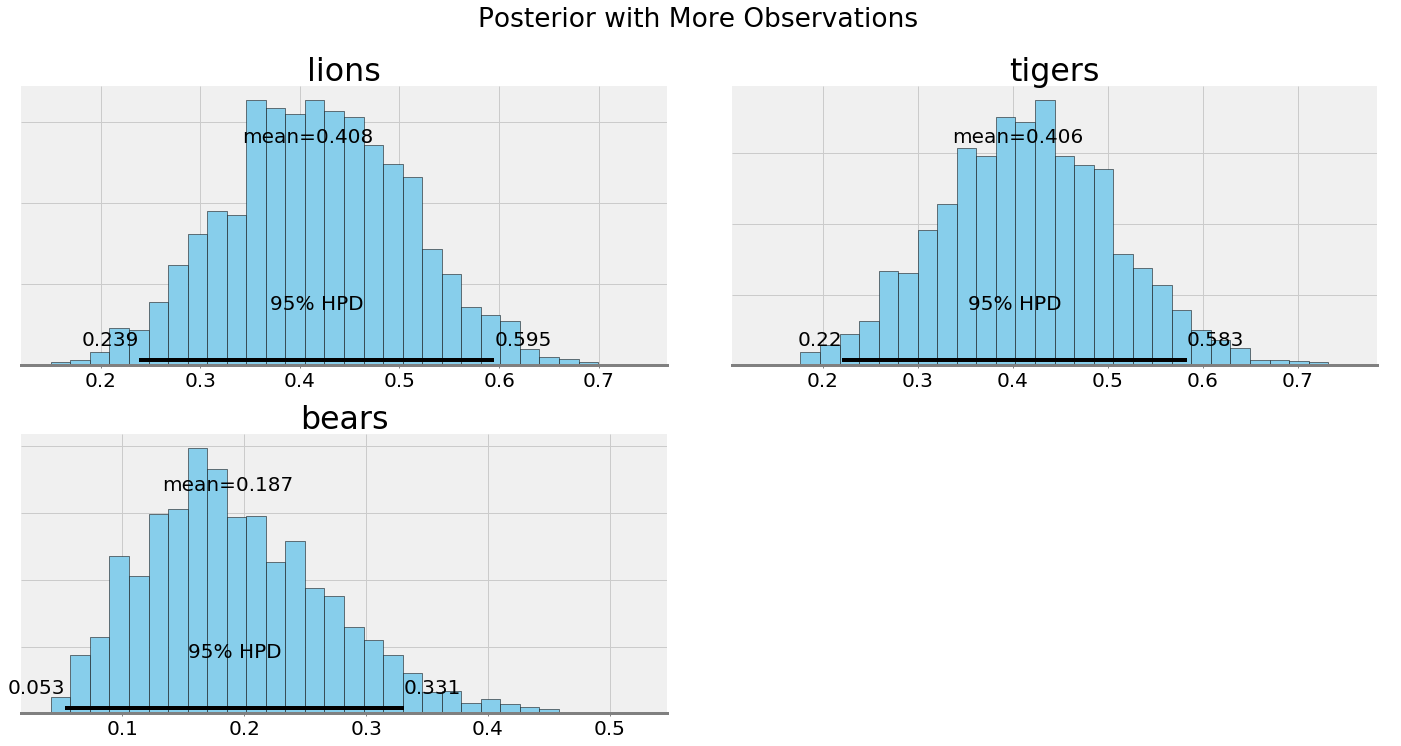

In [30]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle('Posterior with More Observations', y = 1.05);

# Increasing/Decreasing Confidence in Hyperparameters

As noted earlier, we can increase or decrease our confidence in our initial belief by changing the weighting of the hyperparameter vector. Initially we use all 1s, but we can reduce or increase this.

In [31]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

def sample_with_priors(alphas):
    """Sample with specified hyperparameters"""
    with pm.Model() as model:
        # Probabilities for each species
        parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
        # Observed data is a multinomial distribution with 6 trials
        observed_data = pm.Multinomial(
            'observed_data', n=6, p=parameters, shape=3, observed=c)    

        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

In [32]:
trace_dict = {}
for alpha_array in [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 675.17draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 746.04draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 390.55draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 725.70draws/s] 


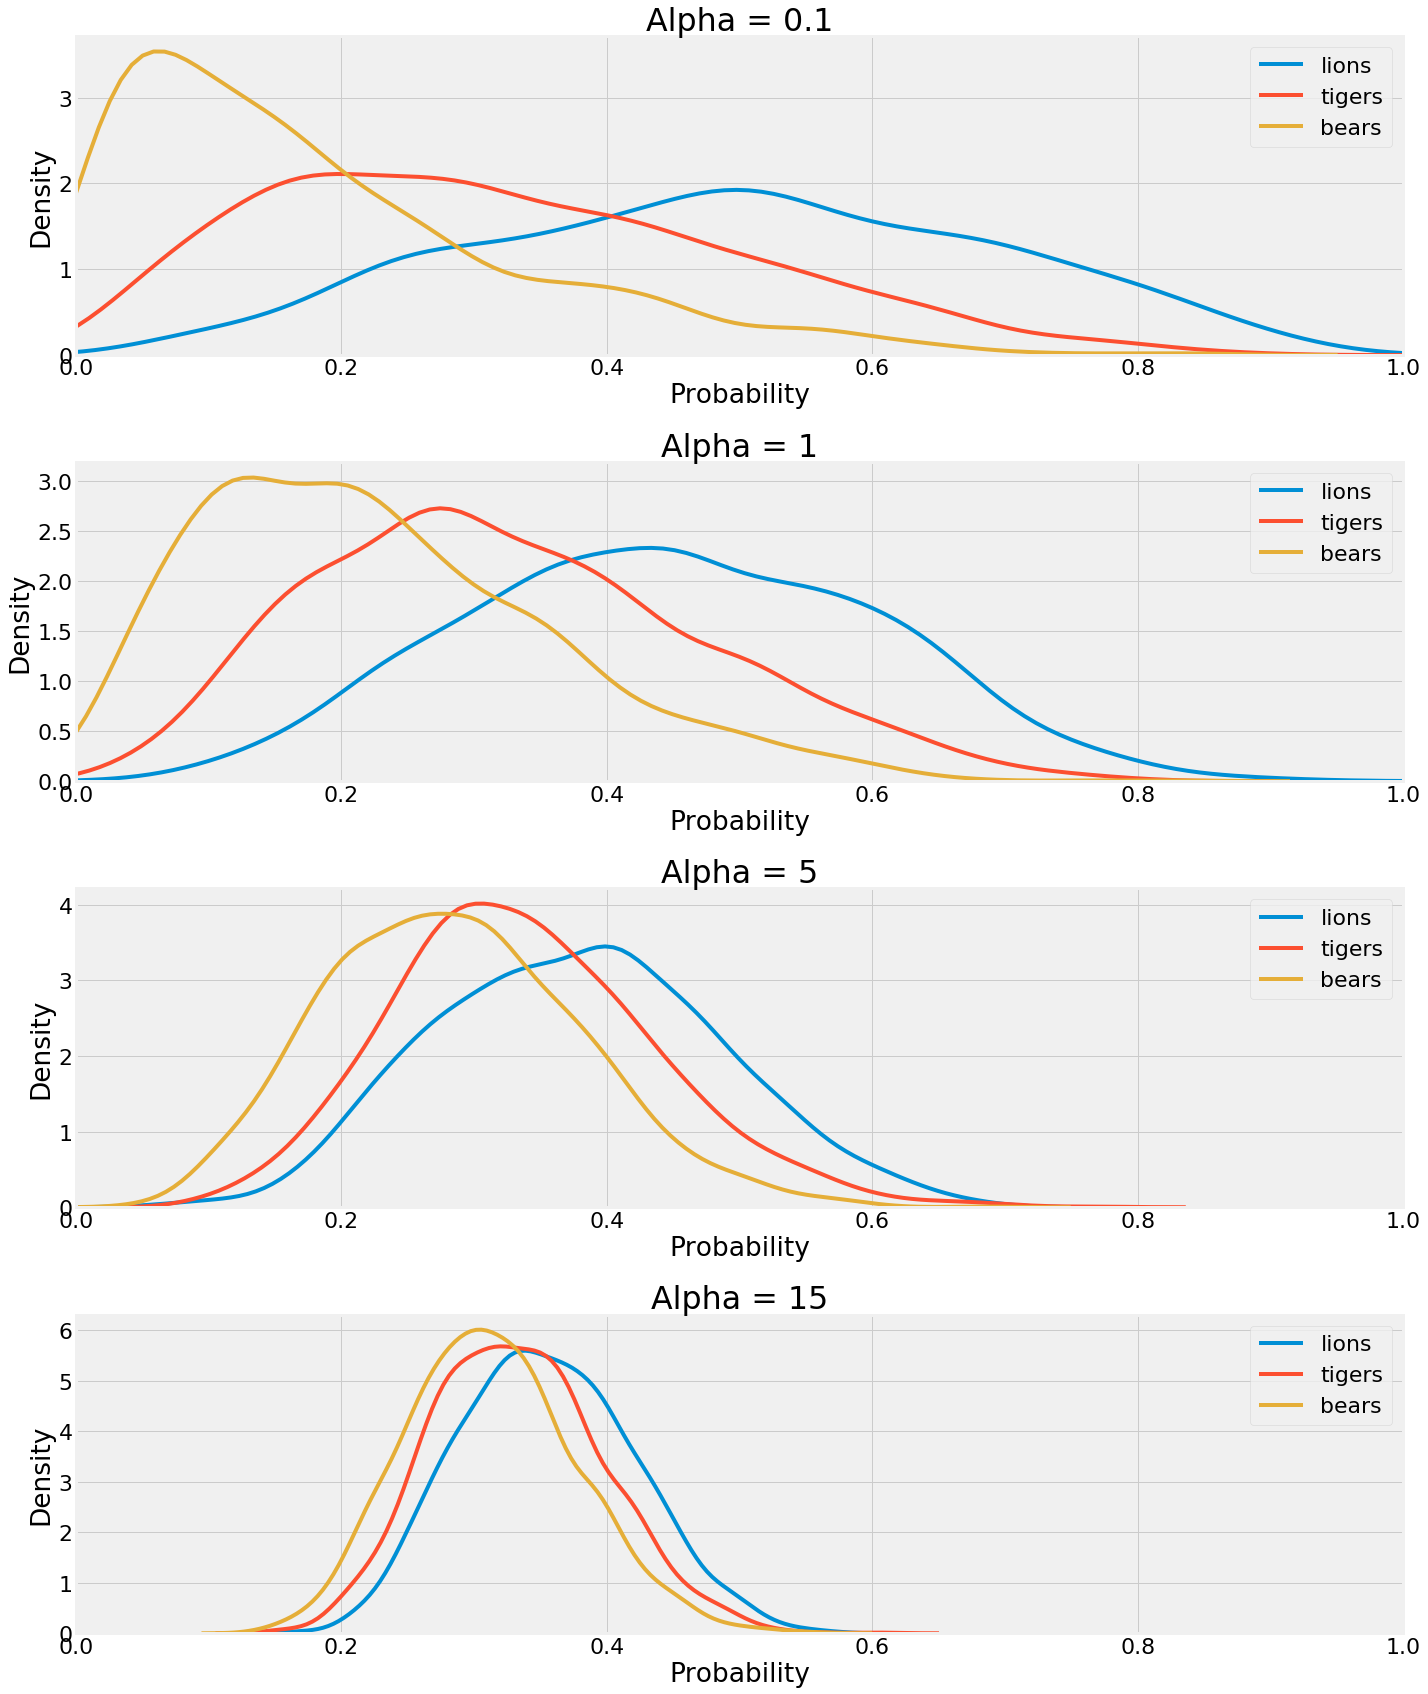

In [33]:
plt.figure(figsize = (20, 24))

for ii, (alpha, trace) in enumerate(trace_dict.items()):
    plt.subplot(4, 1, ii + 1)
    array = trace['parameters']
    for jj, animal in enumerate(animals):
        sns.kdeplot(array[:, jj], label = f'{animal}')
    plt.legend();
    plt.xlabel('Probability'); plt.ylabel('Density')
    plt.title(f'Alpha = {alpha}');
    plt.xlim((0, 1));
    
plt.tight_layout();
plt.show();

As the weight increases, the estimated prevalence tends to collapse to 1/3 for each species. These results are intuitive: if we have a greater belief that the prevalences are equivalent, then the limited data we collected should not change our beliefs greatly.

# Comparison of Beliefs

Next we compare the hyperparameters $\alpha = [0.1, 0.1, 0.1]$ with $\alpha = [15, 15, 15]$

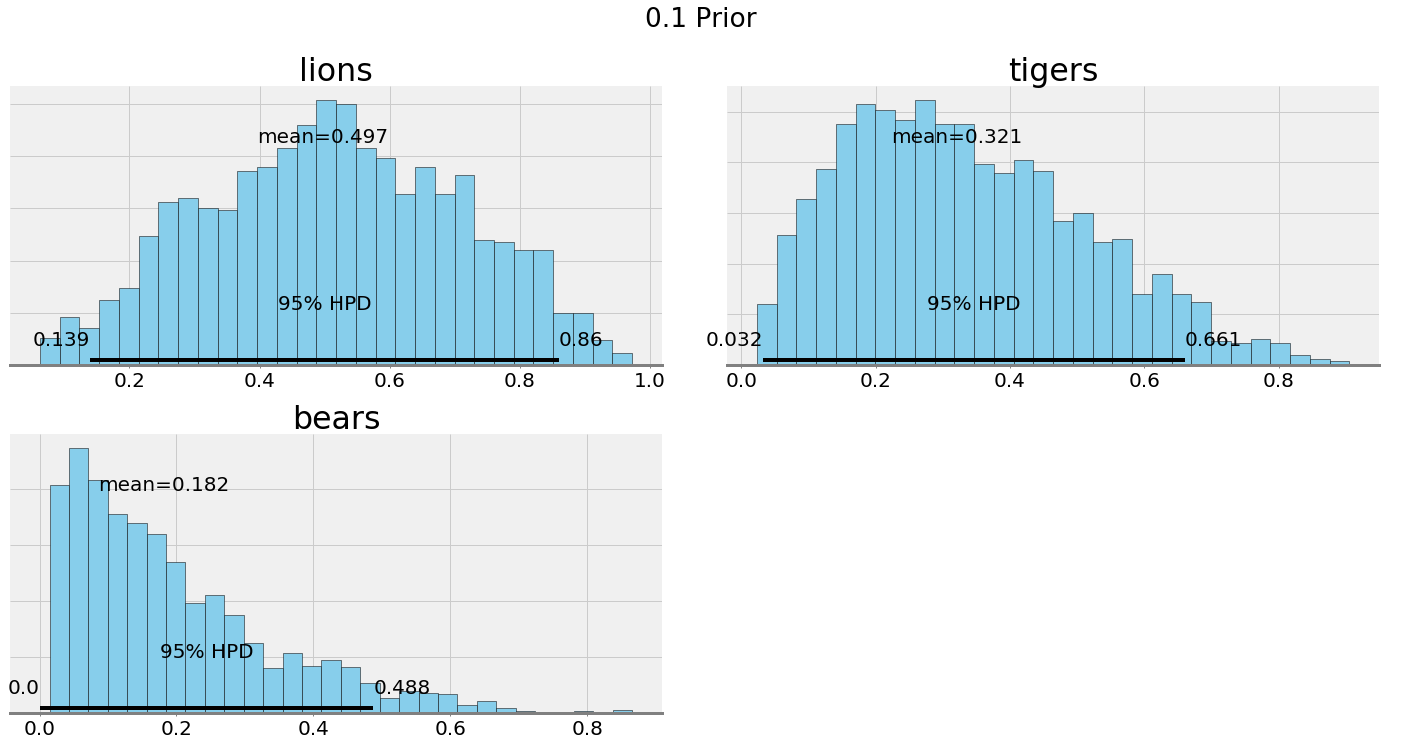

In [34]:
prior = '0.1'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [35]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.497101,0.194166,0.004516,0.139299,0.859773,1638.328563,0.999923
tigers,0.321134,0.177395,0.004615,0.031951,0.660631,1453.101754,0.999510
bears,0.181765,0.150622,0.003606,0.000369,0.487892,1783.371617,1.000014


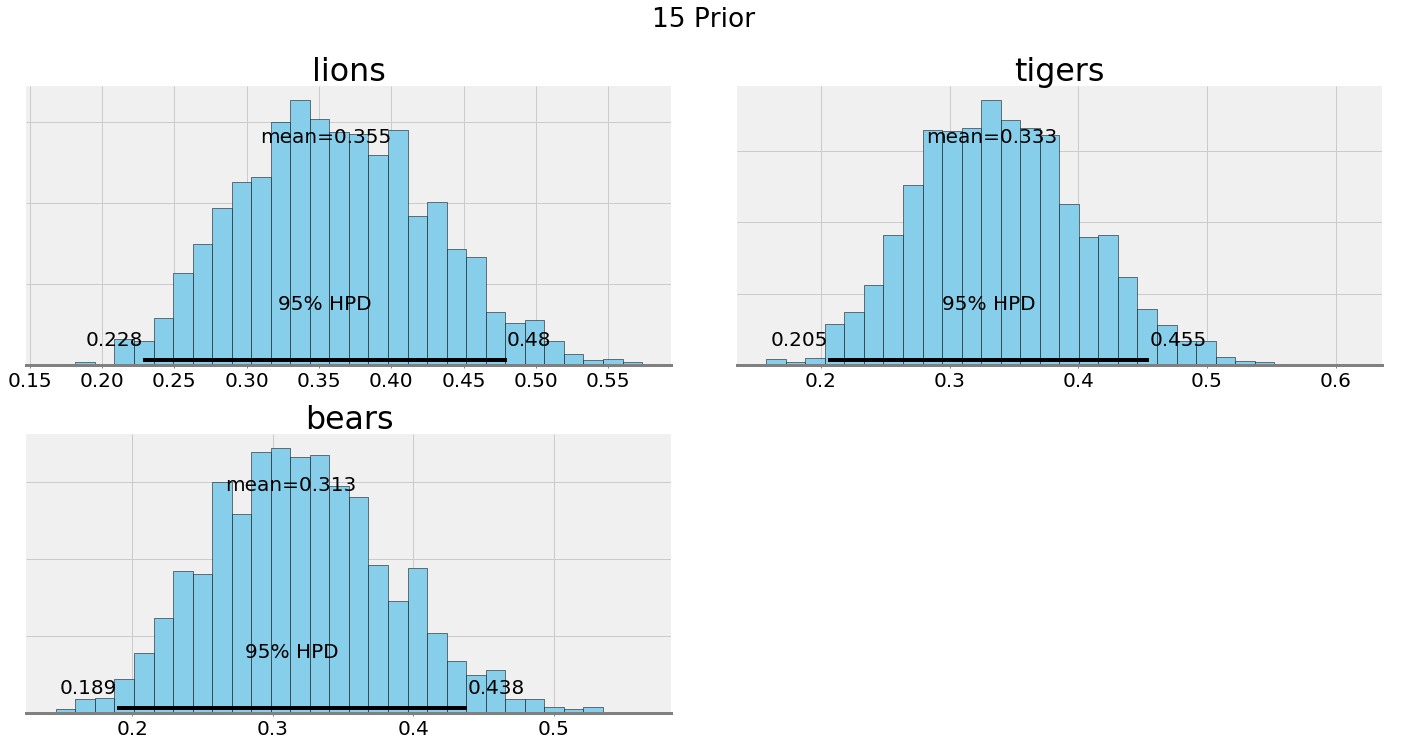

In [36]:
prior = '15'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [37]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.354672,0.065685,0.001704,0.228429,0.480058,1628.991537,0.999511
tigers,0.332637,0.064579,0.001638,0.205349,0.455151,1955.089885,0.999734
bears,0.312691,0.064499,0.001431,0.189082,0.438477,2038.961155,0.999641


Overall, the choice of the hyperpriors depends on our confidence in our initial belief. If we have good reason to believe all the animals are represented at the same frequency, then we should increase the weight of the priors.

# Conclusions

In [38]:
prior = '1'
trace = trace_dict[prior]
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.448250,0.154485,0.003590,0.143697,0.724481,1902.006936,0.999557
tigers,0.326646,0.145182,0.003553,0.060323,0.602743,1610.358764,1.000197
bears,0.225104,0.130979,0.002919,0.005609,0.476906,2071.781730,0.999916



Given the question posed, we can provide the following answers:

__Estimated Prevalence__

Below are the means and 95% HPD for the estimates

* Lions: 44.5% (16.9% - 75.8%)
* Tigers: 32.7% (6.7% - 60.5%)
* Bears: 22.7% (1.7% - 50.0%)

__Probability Next Observation is a Bear__

Based on the sampling, 22.9%. 

(Results may change from one run to the next. This is due to the stochastic nature of MCMC). 

The best parts about Bayesian Inference are the incorporation of priors and the uncertainty inherent in the methods. With the scant evidence, we can provide estimates, but only with a large amount of uncertainty. More visits to the wildlife preserve would certainly help to clear up the matter! 

In this notebook, we were able to explore the basics of Bayesian modeling and probabilistic programming. Although this was only a simple problem, we can use the concepts here to build more complex models. 